# How to control an IDS USB camera

IMPORT LIBRARIES

In [9]:
import matplotlib.pyplot as plt
import ids_peak.ids_peak as ids_peak
import ids_peak_ipl.ids_peak_ipl as ids_ipl
import time
import numpy as np

INITIALIZE AND CONNECT TO THE CAMERA

In [2]:
ids_peak.Library.Initialize()
device_manager = ids_peak.DeviceManager.Instance()
device_manager.Update()
device_descriptors = device_manager.Devices()

print("Found Devices: " + str(len(device_descriptors)))
for device_descriptor in device_descriptors:
    print(device_descriptor.DisplayName())
    
device = device_descriptors[0].OpenDevice(ids_peak.DeviceAccessType_Exclusive)
print("Opened Device: " + device.DisplayName())
remote_device_nodemap = device.RemoteDevice().NodeMaps()[0]

Found Devices: 1
IDS Imaging Development Systems GmbH U3-380xCP-M (1409f499ba31)
Opened Device: IDS Imaging Development Systems GmbH U3-380xCP-M (1409f499ba31)


SET THE TRIGGER PROPERTIES

In [3]:
remote_device_nodemap.FindNode("TriggerSelector").SetCurrentEntry("ExposureStart")
remote_device_nodemap.FindNode("TriggerSource").SetCurrentEntry("Software")
remote_device_nodemap.FindNode("TriggerMode").SetCurrentEntry("On")

START THE STREAM

In [4]:
datastream = device.DataStreams()[0].OpenDataStream()
payload_size = remote_device_nodemap.FindNode("PayloadSize").Value()
for i in range(datastream.NumBuffersAnnouncedMinRequired()):
    buffer = datastream.AllocAndAnnounceBuffer(payload_size)
    datastream.QueueBuffer(buffer)
    
datastream.StartAcquisition()
remote_device_nodemap.FindNode("AcquisitionStart").Execute()
remote_device_nodemap.FindNode("AcquisitionStart").WaitUntilDone()

SET THE EXPOSURE TIME

In [5]:
remote_device_nodemap.FindNode("ExposureTime").SetValue(700) # in microseconds

GRAB A SINGLE IMAGE

In [15]:
remote_device_nodemap.FindNode("TriggerSoftware").Execute()
buffer = datastream.WaitForFinishedBuffer(5000)
raw_image = ids_ipl.Image_CreateFromSizeAndBuffer(buffer.PixelFormat(), buffer.BasePtr(), buffer.Size(), buffer.Width(), buffer.Height())
color_image = raw_image.ConvertTo(ids_ipl.PixelFormatName_Mono12)
datastream.QueueBuffer(buffer)
picture=color_image.get_numpy_2D_16()
raw_image=picture

DISPLAY IMAGE

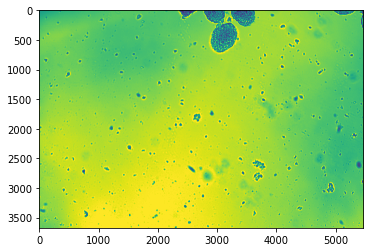

In [16]:
plt.imshow(raw_image)